### Introduction
With the prevalence of COVID-19 leading to extended closures and shutdowns of schools across the world, learning transitioned to mainly in the home. It has led to effects on student learning that has yet to be understood entirely. To examine one aspect, we are looking at the change in students' test scores pre-lockdowns and during lockdowns to better understand the impact remote learning had on students' ability to retain and apply knowledge on exams. We also want to observe if there has been an increase in the spread of student test scores, as some students' household learning will be less affected by the pandemic compared to others. To investigate if there has been an increase in the spread of student test scores, we will look at the standard deviation of test scores pre-lockdown and post-lockdown. We will perform hypothesis testing on mean test scores pre-lockdown and post-lockdown to see if there is a statistically significant difference in test scores.





# Methods and Results 

## Initial Data Wrangling and Visualization 

We began by loading the neccesary packages, reading in our, data and doing some peliminary data wrangling



In [2]:
library(digest)
library(infer)
library(repr)
library(tidyverse)
library(broom)
library(digest)
library(readxl)

url <- "https://raw.githubusercontent.com/dylanc9918/STAT_201_Project/main/COVID_data_csv.csv"

covid <- 
    read_csv(url)
head(covid)

Warning message:
“package ‘infer’ was built under R version 4.1.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘broom’ was built under R version 4.1.3”
Warning message:
“package ‘readxl’ was built under R version 4.1.3”
Rows: 8400 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (18): studentID, sc

studentID,school,gradelevel,gender,covidpos,householdincome,freelunch,numcomputers,familysize,fathereduc,mothereduc,readingscore,writingscore,mathscore,readingscoreSL,writingscoreSL,mathscoreSL,timeperiod
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,6,1,1,59065,0,5,3,1,0,73,69,87,85,83,71,2
1,0,6,1,1,59065,0,5,3,1,0,63,73,57,78,75,58,4
1,0,6,1,1,59065,0,5,3,1,0,80,67,57,88,80,85,1
1,0,6,1,1,59065,0,5,3,1,0,69,56,74,70,48,87,3
1,0,6,1,1,59065,0,5,3,1,0,83,87,65,69,86,66,0
1,0,6,1,1,59065,0,5,3,1,0,62,37,63,82,78,85,5


<b>Table 1</b> The original data frame that had 17 variables with 1400 students in total. And we decide to pick 4 variables that related to our project, which is the `studentID`,`readingscoreSL`, `writingscoreSL`, `mathscoreSL` and `timeperiod`. We chose to analyze the student test scores on the State Level (SL) tests as this would control for any variability in the tests offered specific to the school and allow this to more applicable to the general student population of the state. In the timeperiod variable, timeperiods 1 -3 indicate assesments that were pre-covid, otherwise, time periods 4-6 indicate assements that were post-covid. To get the mean score of students in these 3 subjects in pre and post covid, we first sum up the math, reading, and writing score into one total summation score for each of the 6 time periods. We then averaged  across the three time periods that were pre and post covid to give us a single score for pre and post covid, and it is shown in <b>Table 2</b>.

In [3]:
covid_n <- covid %>%
#changing timeperiod to either 0 or 1, 0 represents pre-COVID and 1 represents post-COVID
mutate(timeperiod = as.integer(timeperiod / 3))%>%
mutate(time = ifelse(timeperiod < 1, "pre_covid","post_covid"))%>%

# we only want these 5 column
select("studentID", "readingscoreSL", "writingscoreSL", "mathscoreSL", "time")%>%

#creating a new column that summary of students' average of all score of the state level test
mutate(scoresumSL = (readingscoreSL + writingscoreSL + mathscoreSL))%>% 


#group by student and the time period 
group_by(studentID, time)%>%

# mean of all test scores taken across the three measures for each time period
summarize(meanscore = mean(scoresumSL)) 

head(covid_n)

`summarise()` has grouped output by 'studentID'. You can override using the
`.groups` argument.


studentID,time,meanscore
<dbl>,<chr>,<dbl>
1,post_covid,220.3333
1,pre_covid,237.6667
2,post_covid,193.3333
2,pre_covid,219.3333
3,post_covid,200.6667
3,pre_covid,247.6667


<b>Table 2</b> Table containing mean scores for each student on the state level tests pre and post covid.

In [4]:

#pivots dataframe wider so contains columns pre and post covid with associated values
covid_wider <- pivot_wider(covid_n, names_from = time , values_from = meanscore)

head(covid_wider)

#extracts columns for pre-covid
covid_pre <- covid_wider%>%
    ungroup()%>%
    select(pre_covid)


#extracts columns for post-covid
covid_post <- covid_wider%>%
    ungroup()%>%
    select(post_covid)


studentID,post_covid,pre_covid
<dbl>,<dbl>,<dbl>
1,220.3333,237.6667
2,193.3333,219.3333
3,200.6667,247.6667
4,223.6667,255.0000
5,190.0000,238.3333
6,238.3333,265.3333


<b>Table 3</b> Result from pivoting table 2 wider in order to have separate columns for pre and post covid for easier readability and to make future bootstrapping easier 

In [13]:
covid_wider_summary<- covid_n %>%
ungroup()%>%
group_by(time)%>%
summarize(n=n(), Mean = mean(meanscore),Variance= var(meanscore), Median= median(meanscore),Min=min(meanscore),Max=max(meanscore))


covid_wider_summary


time,n,Mean,Variance,Median,Min,Max
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
post_covid,1400,203.0838,462.8237,203.3333,145.6667,261
pre_covid,1400,227.1050,473.4412,227.6667,165.6667,283


<b>Table 4</b> Showing the number of students, the mean, variance, median, minimum, and maximum of test scores for both pre and post covid

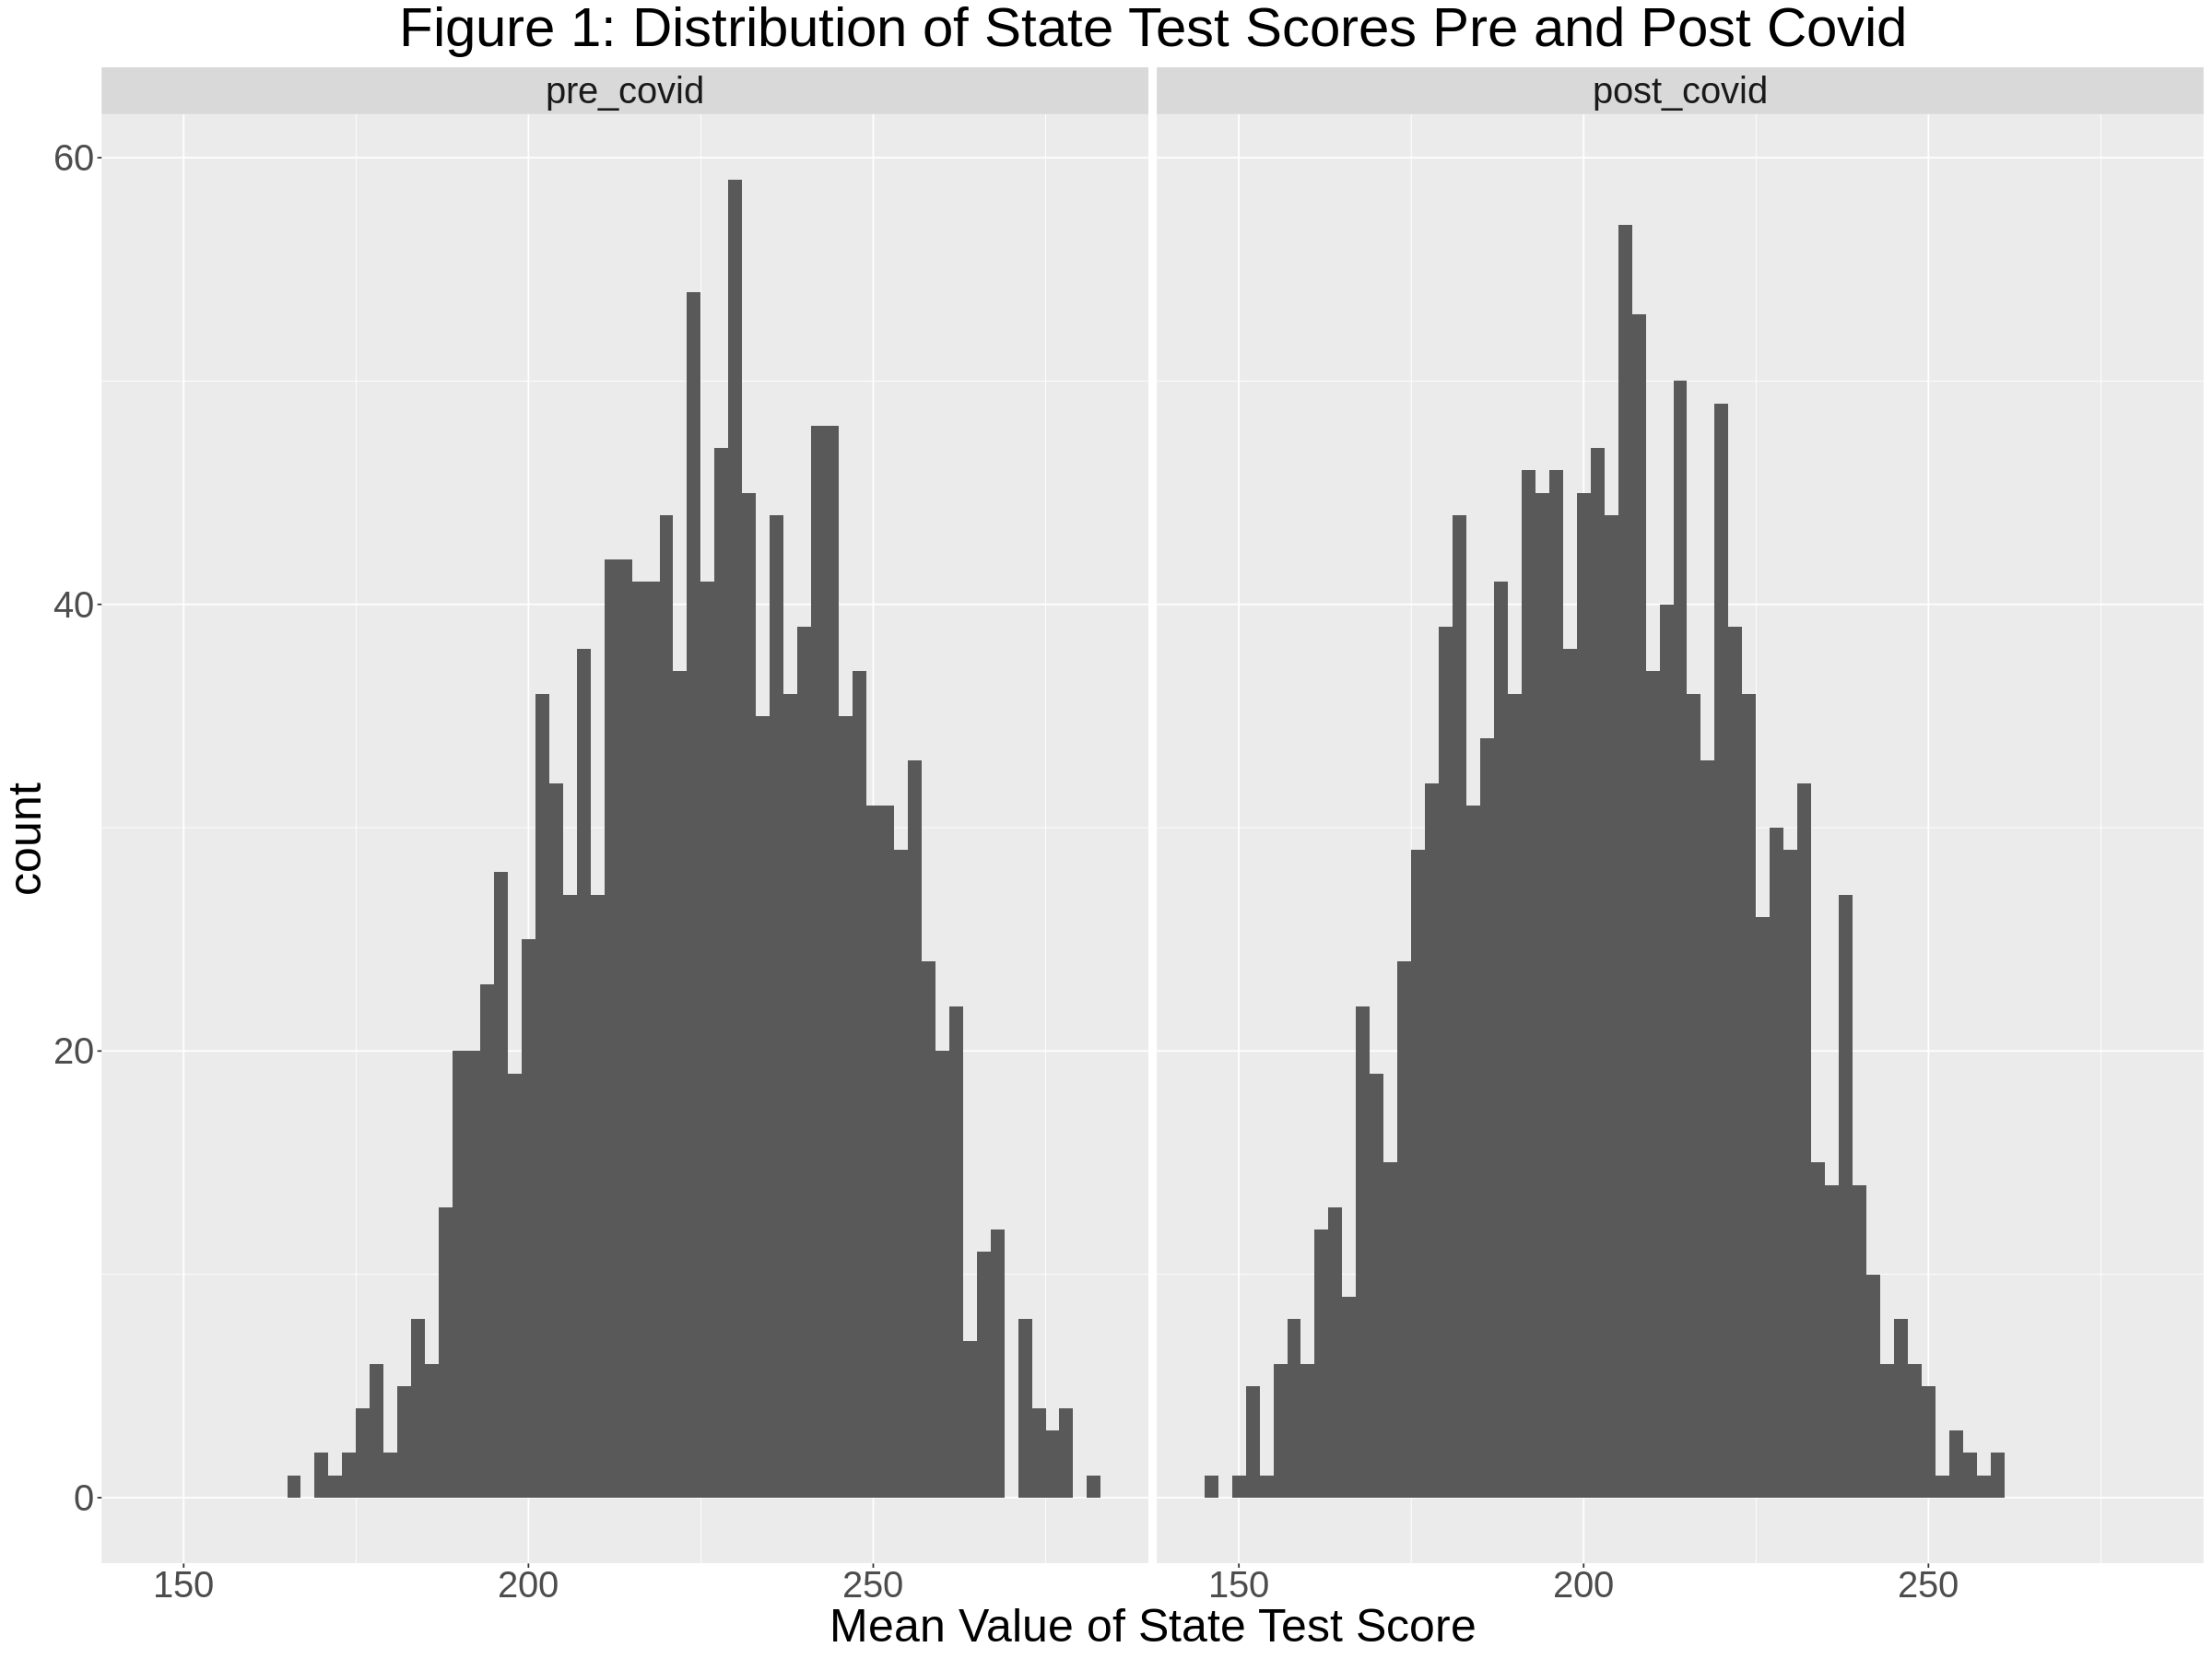

In [6]:
options(repr.plot.width = 20,repr.plot.height = 15)
covid_samp_dist_plot <- 
    covid_n %>% 
    ggplot() + 
    geom_histogram(aes(x = meanscore), binwidth = 2) +
    facet_wrap(~ factor(time,levels = c("pre_covid","post_covid"))) + 
    xlab("Mean Value of State Test Score")+
    ggtitle("Figure 1: Distribution of State Test Scores Pre and Post Covid")+
    theme(text = element_text(size = 30),plot.title = element_text(hjust = 0.5))
covid_samp_dist_plot


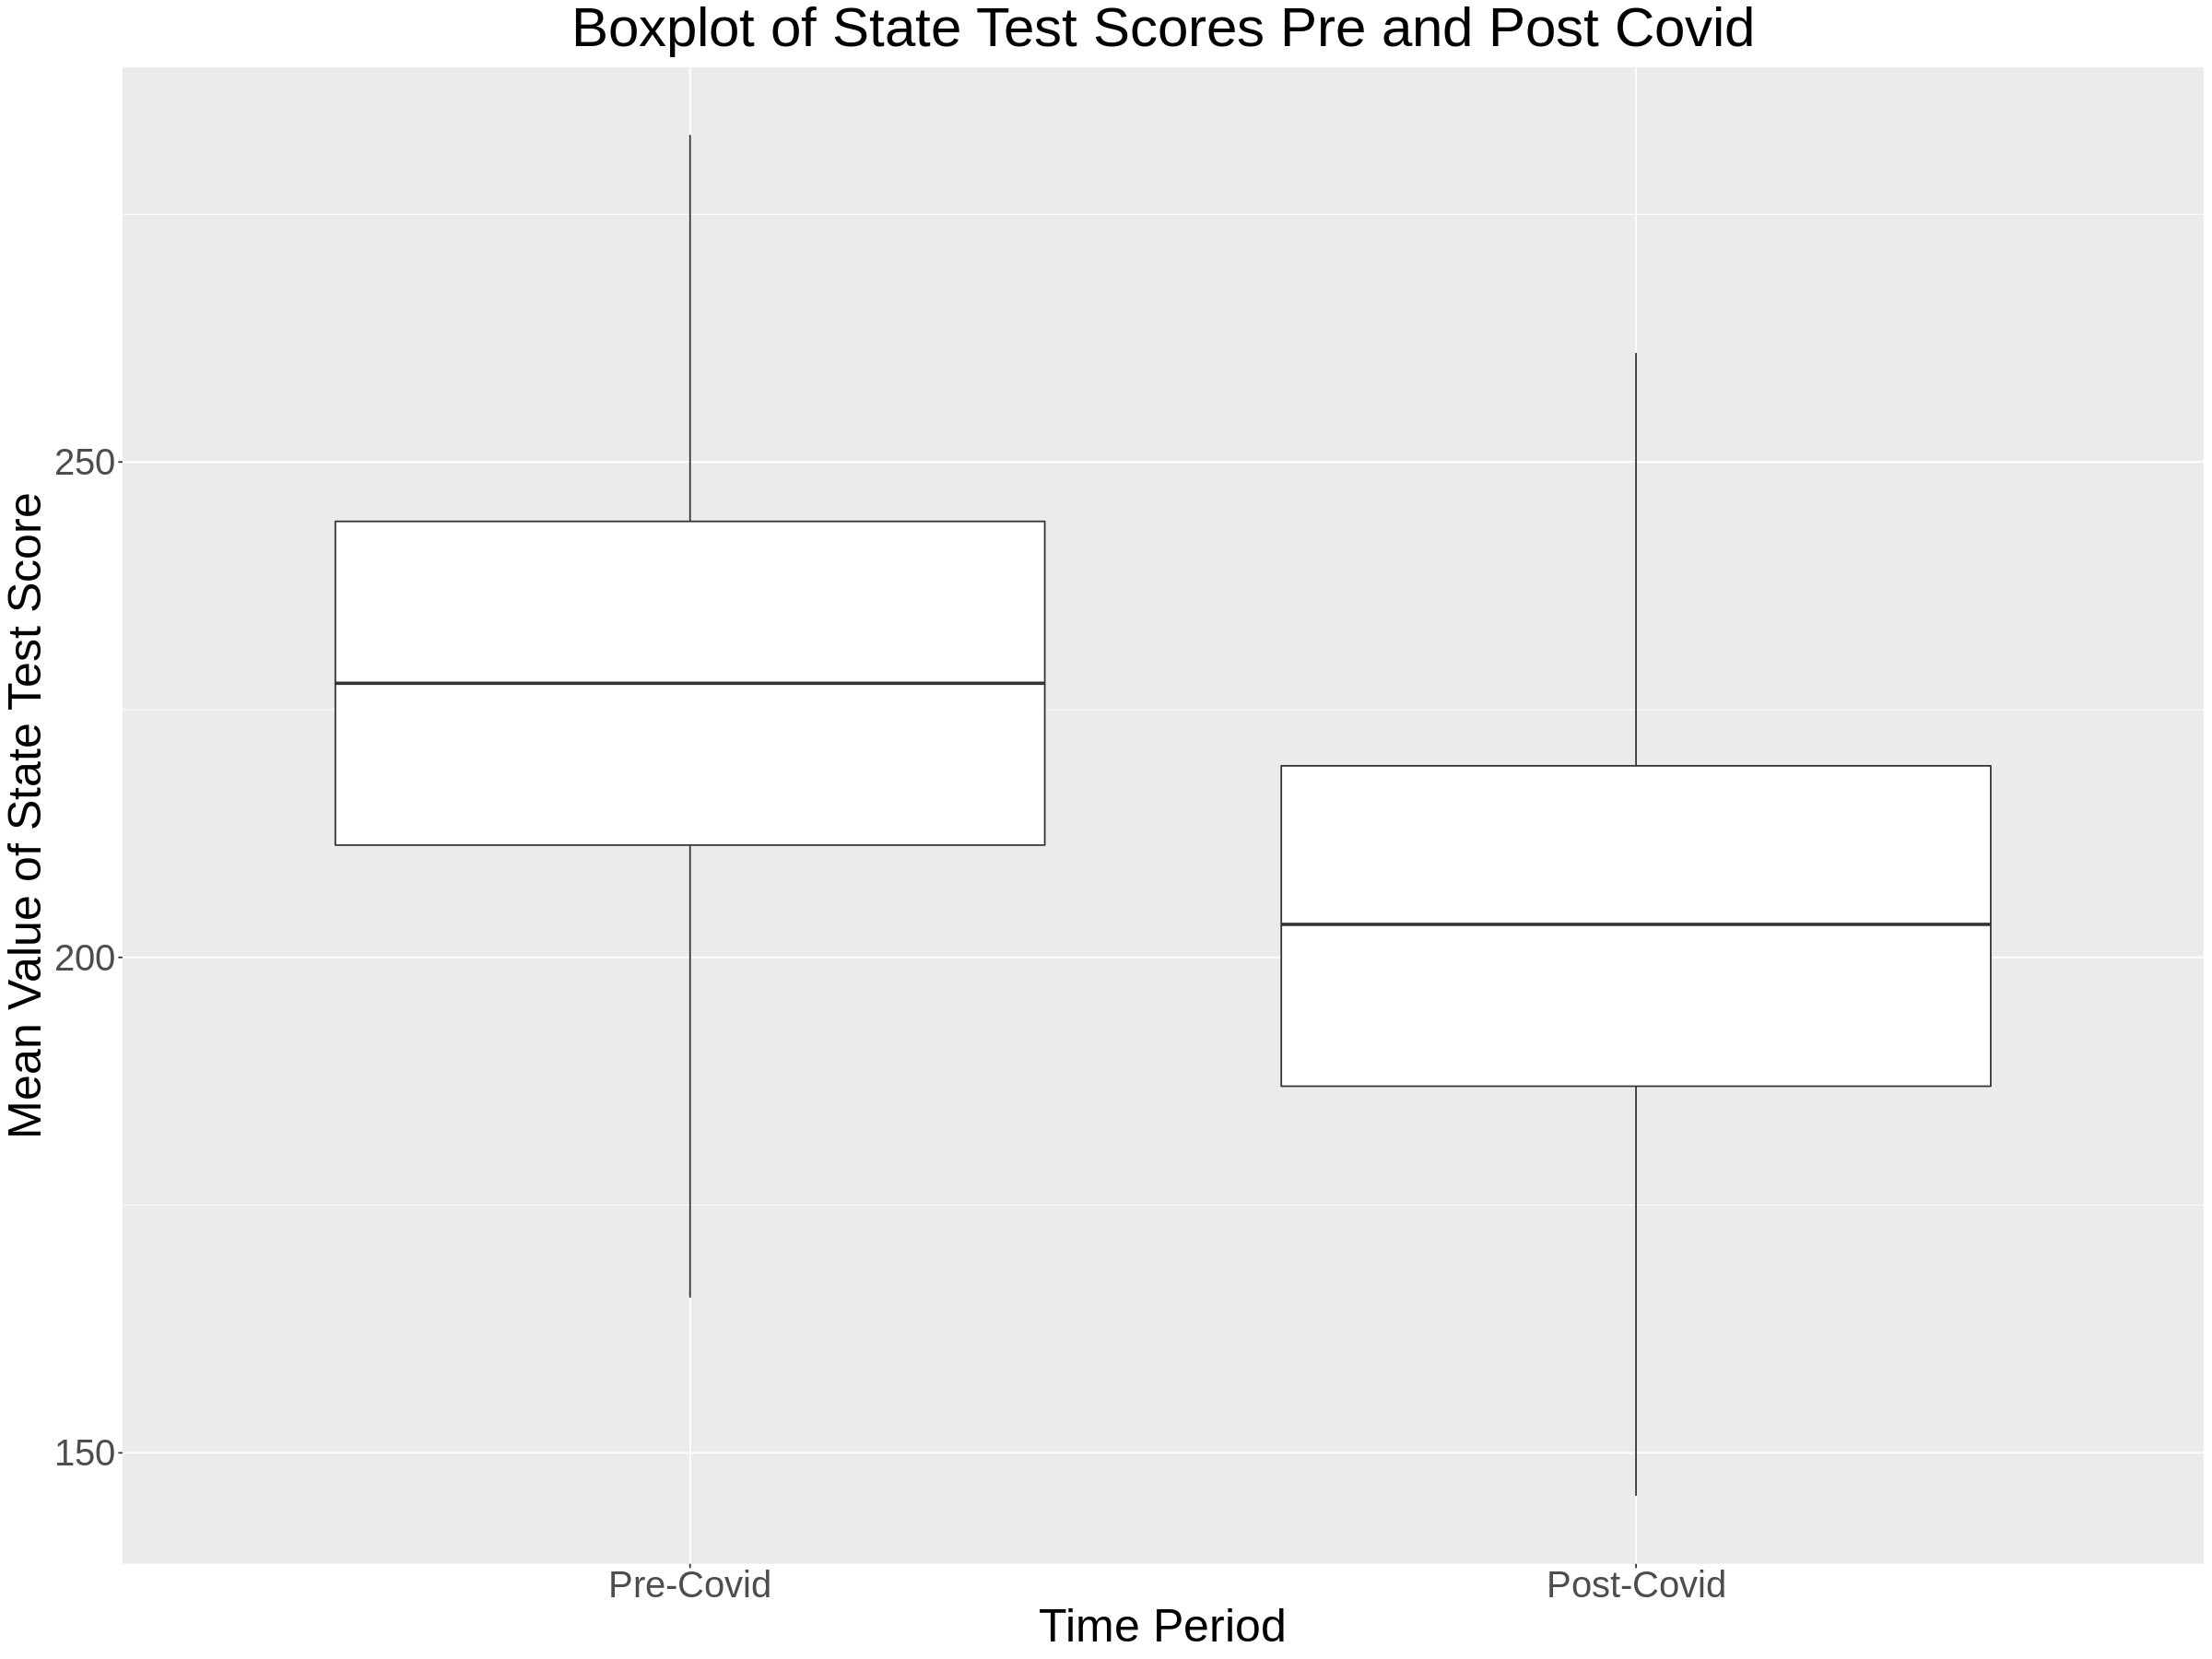

In [7]:


#create a box plot of distribution pre and post covid
covid_box_plot<- covid_n %>%
ggplot()+
geom_boxplot(aes(x= factor(time,levels = c("pre_covid","post_covid")), y = meanscore))+
xlab("Time Period")+
ylab("Mean Value of State Test Score")+
ggtitle("Boxplot of State Test Scores Pre and Post Covid")+
theme(text = element_text(size = 30),plot.title = element_text(hjust = 0.5))+
scale_x_discrete(labels=c("Pre-Covid", "Post-Covid"))


covid_box_plot

<b>Figure 1</b> is a histogram visualizalize of the distributions of mean state test score in pre and post covid period. The pre-covid and post-covid graphs are both in unimodel without skew. The values on the x axis are the mean test scores that were computed as outlined above for each the students pre and post covid and the count is shown on the y-axis. 
<b>Figure 2</b> is a boxplot also shows the distributions of mean state test score in pre and post covid period. It shows that that the median of the state test scores is different in pre and post covid. As these populations are made up of the same students pre and post covid, this is a dependent population. We are interested in finding the difference between student average score perforance before and after covid. We decide to use paired t-test with degrees of freedom of 1399 (one less than our population of 1400 students) to compute our analysis. From the preliminary analysis result from  <b>table 3</b>, <b>Figure 1</b> and <b>Figure 2</b>, we could see that there is both a difference in mean score with pre and post covid scores 
203.0838 and 227.1050 respectively, and variance with pre and post covid scores variance of 473.4412 and 462.8237 respectively. 


## Methods

From our sample data, the mean difference in state test score in pre and post covid period is our point estimate and through the use of a paired t.test we could determine if this difference is significant based on the returned p-value.

In [8]:
# perform a paired t-test on pre and post covid means to see if there is a statistically signfigant difference between the two of them
covid_mean <- t.test(covid_wider$pre_covid, covid_wider$post_covid, paired = TRUE, alternative = "two.sided")

covid_mean
#extract the p-value
print(covid_mean$p.value)


	Paired t-test

data:  covid_wider$pre_covid and covid_wider$post_covid
t = 56.842, df = 1399, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 23.19220 24.85018
sample estimates:
mean of the differences 
               24.02119 


[1] 0


From this analysis we can see that our returned p-value based on this test statistic is so low that R is unable to represent it with a number hence the return of the number 0. This would indicate a significant difference in test scores between pre and post covid allowing us to reject the null hypothesis that there is no difference.


In order to analysis our variance we would be using a two-way ANOVA test. This would allow us to study the impact our two groups (pre and post covid) have on the variable being studied, test scores. Using a two way ANOVA test we would calculate the F-statistic which assumes a normal distribution which from our Figure 1 we can see that both our populations roughly follow.

In [9]:
#performed a F-test on variance to see if they are statitistically signfigant in difference 
aov_model <- aov(meanscore ~ time, data = covid_n)
summary(aov_model)
summary(aov_model)[[1]][["Pr(>F)"]][1]



              Df  Sum Sq Mean Sq F value Pr(>F)    
time           1  403912  403912   862.8 <2e-16 ***
Residuals   2798 1309835     468                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[1] 1.535393e-165

Calculating the p-value associated with the F-statisic above we can see that its extremely small and many magnitudes below our alpha value. Meaning that we can reject our null hypothesis that there is no difference in measured variance. 

### Bootstrapping

After determining that there was statistically significant difference in both the mean and variance of our two populations we performed bootstrapping in order to obtain confidence intervals that would allow us to give an estimated range of the true population parameter. As we are only dealing with one sample for this analysis bootstrapping would allow us to recreate the resampling of our population from our original population and give us a range of possible values. Using bootstrapping, there is no need to assume that our observations, or the underlying populations, are normally distributed. Thanks to the Central Limit Theorem, the resampling distribution of the effect size will approach a normality. Using the infer package we created 1000 resamples from which we created 95% confidence intervals for our difference in means between the two populations. 

In [10]:
#perform bootstrapping on paired population to find CI in mean
set.seed(514)

bootstrap_mean <- covid_n %>% 
  specify(formula = meanscore ~ time) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "bootstrap") %>% 
  calculate(stat = "diff in means", order = c("pre_covid", "post_covid"))%>%
    get_confidence_interval(level = 0.95, type = "percentile")
bootstrap_mean





lower_ci,upper_ci
<dbl>,<dbl>
22.37414,25.60643


From our bootstrap analysis we generated 95% confidence interval of 22.374 to 25.606 difference in means between pre-covid minus post-covid (i.e pre-covid had higher mean test scores than post-covid). The 95% indicates that any such confidence interval will capture the population mean difference 95% of the time. In other words, if we repeated our experiment 100 times, gathering 100 independent sets of observations, and computing a 95% CI for the mean difference each time, 95 of these confidence intervals would capture the population mean difference.

We repeat the same process for our analysis of variance this time we use rep_sample_n to resample our two separate populations of pre-covid and post-covid test scores that we created earlier. In order to study the difference in variance of our two populations we were unable to use the infer package and would have to rely on creating individual bootstrapping samplings of each population. We then calculated the variance of each replicate in the bootstrap sampling of the two populations. With these populations and their variance calculated we could perform a t.test to calculate the 95% CI. The t.test was performed with the conditions specifying that this was a paired populaton with paired = TRUE and that the alternative hypothesis was "two.sided" as our altnerative was that they were not equal to eachother (CI does not need to be specified as the default is 95%).

In [11]:
# #perform bootstrapping on pre-covid and calculate variance of all replicates
set.seed(514)

bootstrap_pre <- covid_pre %>% 
    rep_sample_n(size = nrow(covid_pre), reps = 1000, replace = TRUE)%>%
    group_by(replicate) %>% 
    summarize(boot_var = var(pre_covid))


# #perform bootstrapping on post-covid and calculate variance of all replicates
bootstrap_post <- covid_post %>% 
    rep_sample_n(size = nrow(covid_post), reps = 1000, replace = TRUE)%>%
    group_by(replicate) %>% 
    summarize(boot_var = var(post_covid))

#perform a t-test on parired populations after bootstrapping
covid_var <- t.test(bootstrap_pre$boot_var, bootstrap_post$boot_var, paired = TRUE, alternative = "two.sided")

covid_var$conf

[1]  8.03439 10.53930
attr(,"conf.level")
[1] 0.95

From this analysis we can see that the 95% CI for our differences in variances is 8.034 - 10.539 for pre-covid minus post-covid (i.e pre-covid had higher variances than post-covid).

### Discussion 

Based on the above data and results under 95% confidence interval, we find that COVID has a great impact on students' state exam grades in middle school and high school. Average students' state exam grades has significantly decreased 24.02 points after COVID-19 lockdown happened and study mode switched from in-person to online. Also, the variance of students' grades also increased after covid, which means the difference between students has been enlarged. These two results scientifically indicates that online learning has a negatively affected students on their study, by not only lowering students grades on average(which means the majority of students has been impacted), but also make the difference between students even larger than before(the weaker students are now harder to catch up). Based on what we found, we can warn people that the teaching method or the learning method we used at COVID-19 lockdown was not efficient, and realtive changes should be made in advance to provide a better teaching and learning environment before next similar event happens.

Our finding basically conform to what we expected before the project, since there are lots of study shoulded that COVID-19 lockdown has a negative effect on students learning experience and outcome, our study scientifically proves this point from the aspect of data analysis. However, the result shows that COVID-19 lockdown has a even larger impact on students grade than what the previous study's result and what we expected.

Our study is just a beginning of the topic on COVID-19's impact on students' study experience, many future questions can be addressed from what we found. Since COVID-19 lockdown has negative effect on students' grades, which subject is impacted most severely? When students get used to this study mode, will their grades improve back to what there were before COVID-19? Does different COVID-19 policies in different schools further affects students grades? 





The benefits of this report are that we have a relatively large sample size to work with 1400 students in total, for this sufficiently large sample size we can assume under CLT that our distribution is approximately normal, and under this assumption, we can calculate our z-score to determine if our difference in means is statistically significant. In addition, the tests are standardized across all students for all schools as every school takes the same state test, which will control for any differences between tests at different schools. Our current plots and summaries are a good start to visualizing our distribution and mean for our two categories, but this is insufficient for determining if our findings are significant. 

Under a null hypothesis that there is no difference (with an alternate hypothesis that the means are different) we will use the normal distribution to determine if the difference in our means is statistically significant under a 5% significance level. Should we find a statistically significant difference in means we will perform bootstrapping to construct confidence intervals that will give us a range of reasonable values for our difference in means under a 95% confidence interval. Additional research has already been performed on this topic in 2022 Brown University surveyed 5.4 million U.S. primary students' performance, and showed a decrease of 0.2-0.27 standard deviations in maths scores and 0.09-0.18 standard deviation decrease in reading scores from 2019 to 2021 (Kuhfeld et al. 2022). That same study also found a widening gap in the achievements of poverty stricken students compared to their wealthier peers. 

We hope to add our own findings on this and share more information about how students test scores have changed in the aftermath of lockdowns and transition to more remote learning. This findings could force us to reevaluate how students learn and to implement new strategies that allow all students even footing to learn even from home. This will beg the question if it is possible for all students to receive an adequate education from home or if in person in school is the only path forward for student progress



We input the seed() function at the coding section's first row to ensure the data is reproducible

### References
- BOLLARD, D.Y.L.A.N. (no date) COVID-19 Effect on Grades. Available at: https://www.kaggle.com/datasets/dylanbollard/covid19-effect-on-grades-constructed-dataset?resource=download. 
- Kuhfeld, M., Soland, J. and Lewis, K. (2022) COVID-19 Effect on Grades [Preprint]. Available at: https://doi.org/Soland, J., Lewis, K., & Kuhfeld, M. (2022). (rep.). Test Score Patterns Across Three COVID-19-impacted School Years (Vol. 29). Portland, OR. . 
- Al Shaibani, T. et al. (2021) “Impact of COVID-19 pandemic on students’ performance in a problem-based learning system: comparative study between face-to-face-and virtual learning,” 9. Available at: https://doi.org/file:///Users/apple/Downloads/Impact_of_COVID-19_pandemic_on_students_performan.pdf. 
